In [18]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
from matplotlib.ticker import ScalarFormatter
import pandas as pd
import math as math

import orekit_jpype
vm = orekit_jpype.initVM()
from orekit_jpype.pyhelpers import setup_orekit_curdir
setup_orekit_curdir()

from org.orekit.frames import FramesFactory, TopocentricFrame
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint
from org.orekit.time import AbsoluteDate, TimeScalesFactory
from org.orekit.propagation.analytical.tle import TLE, TLEPropagator
from org.orekit.propagation.events import ElevationDetector, EventsLogger
from org.orekit.propagation.events.handlers import EventHandler
from org.orekit.utils import Constants, IERSConventions
from org.hipparchus.ode.events import Action
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.bodies import CelestialBodyFactory
from org.orekit.models.earth import EarthStandardAtmosphereRefraction


from math import radians, pi
import math
import pandas as pd
from datetime import datetime
import jpype
from jpype import JImplements, JOverride


JVM already started, resuming on started JVM


In [19]:
def celestial_body_ephemeris(body_name, gs_lat, gs_long, gs_alt, duration_days=30, dt_seconds=3600, min_elevation=5):
    """
    Compute the topocentric (altitude, azimuth) coordinates of a celestial body
    (e.g. Moon or Mars) relative to a ground station over a given time span.
    
    Parameters:
      body_name:   String, e.g., 'moon' or 'mars'
      gs_lat:      Ground station latitude (degrees)
      gs_long:     Ground station longitude (degrees)
      gs_alt:      Ground station altitude (meters)
      duration_days: Duration (in days) for sampling the propagation
      dt_seconds:  Sampling interval in seconds
      min_elevation: Minimum elevation angle (in degrees)
      
    Returns:
      A pandas DataFrame containing time, elevation, azimuth and range.
    """
    # Set up the ITRF frame and earth model
    ITRF = FramesFactory.getITRF(IERSConventions.IERS_2010, True)
    earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                               Constants.WGS84_EARTH_FLATTENING,
                               ITRF)

    # Define the ground station and its topocentric frame
    station = GeodeticPoint(math.radians(gs_lat), math.radians(gs_long), gs_alt)
    station_frame = TopocentricFrame(earth, station, "Station")

    # Define the inertial frame (EME2000)
    inertialFrame = FramesFactory.getEME2000()

    # Get the celestial body
    if body_name.lower() == 'moon':
        body = CelestialBodyFactory.getMoon()
    elif body_name.lower() == 'mars':
        body = CelestialBodyFactory.getMars()  # Might need a SPICE-based approach??
    else:
        raise ValueError("Unsupported celestial body. Use 'moon' or 'mars'.")

    # Set up time interval for sampling
    current_utc = datetime.utcnow()
    initialDate = AbsoluteDate(current_utc.year, current_utc.month, current_utc.day,
                               current_utc.hour, current_utc.minute, float(current_utc.second),
                               TimeScalesFactory.getUTC())
    finalPropagationDate = initialDate.shiftedBy(duration_days * 24 * 3600)

    data = []
    current_date = initialDate
    while current_date.compareTo(finalPropagationDate) < 0:
        # Get the body's state at the current time (inertial frame)
        pv = body.getPVCoordinates(current_date, inertialFrame)
        pos_inertial = pv.getPosition()
        
        # Compute topocentric horizon coordinates
        el_rad = station_frame.getElevation(pos_inertial, inertialFrame, current_date)
        el_deg = math.degrees(el_rad)
        az_rad = station_frame.getAzimuth(pos_inertial, inertialFrame, current_date)
        az_deg = math.degrees(az_rad)

        # Apply atmospheric corrections to elevation (Not 100% sure this is correct? But the effect is very small, and looks reasonable)
        refraction_model = EarthStandardAtmosphereRefraction()
        correction_rad = refraction_model.getRefraction(el_rad)
        # print(math.degrees(correction_rad))
        el_rad_apparent = el_rad + correction_rad
        el_deg_apparent = math.degrees(el_rad_apparent)

        
        # Append the computed values to the data list.
        data.append({
            "Date (UTC)": str(current_date),
            "Elevation (deg)": el_deg,
            "Apparent Elevation (deg)": el_deg_apparent,
            "Azimuth (deg)": az_deg
        })
        
        # Move to the next time step
        current_date = current_date.shiftedBy(dt_seconds)

    df = pd.DataFrame(data)
    
    filtered_df = df[df["Elevation (deg)"] >= min_elevation]

    return filtered_df


# Define GS

In [20]:
def ddhhmmss_to_decimal(degrees, hours, minutes, seconds):
    return degrees + (hours / 60) + (minutes / 3600) + (seconds / 3600)

# Coordinates: 57°33'33.2748'' N ; 21°50'50.6616'' E ; 50.1m 
# Example: Convert 12° 34' 56.78'' (12 hours, 34 minutes, 56.78 seconds)
latitude = ddhhmmss_to_decimal(57, 33, 33, 2748)
longitude = ddhhmmss_to_decimal(21, 50, 50, 6616)
altitude = 50.1

# Calculate Ephemeris

In [21]:
duration_days = 365*3

df = celestial_body_ephemeris("moon", latitude, longitude, altitude, duration_days, dt_seconds=3600)
df


,Date (UTC),Elevation (deg),Apparent Elevation (deg),Azimuth (deg)
13,2025-02-25T07:56:02.000Z,6.412634,6.545220,174.067256
14,2025-02-25T08:56:02.000Z,6.476564,6.608077,187.361215
36,2025-02-26T06:56:02.000Z,5.897443,6.039311,147.897909
37,2025-02-26T07:56:02.000Z,9.372191,9.467789,161.207047
38,2025-02-26T08:56:02.000Z,11.157027,11.238471,174.980696
...,...,...,...,...
26271,2028-02-24T09:56:02.000Z,19.226512,19.274123,180.695268
26272,2028-02-24T10:56:02.000Z,18.322100,18.372147,195.841119
26273,2028-02-24T11:56:02.000Z,15.491149,15.550469,210.568831
26274,2028-02-24T12:56:02.000Z,11.000701,11.083226,224.592163


# Plot Histogram

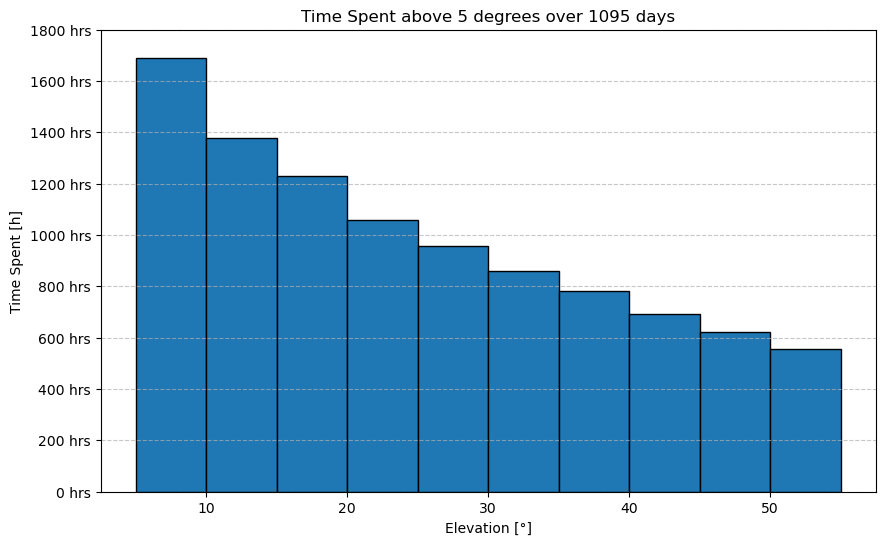

In [26]:
import matplotlib.pyplot as plt

# Define bin edges (ensuring alignment with 5-degree bins)
bin_edges = np.arange(int(df["Elevation (deg)"].min()) // 5 * 5, 
                      int(df["Elevation (deg)"].max()) // 5 * 5 + 5, 5)

# Create histogram
fig, ax = plt.subplots(figsize=(10, 6))
counts, bins, patches = ax.hist(df["Elevation (deg)"], bins=bin_edges, edgecolor='black')

# Scale y-axis to represent time spent (assumes dt = 1 hour)
time_spent_hours = counts

# Update y-axis labels
ax.set_yticks(ax.get_yticks())  # Preserve the default tick locations
ax.set_yticklabels([f"{int(tick)} hrs" for tick in ax.get_yticks()])  # Convert to hours


plt.xlabel("Elevation [°]")
plt.ylabel("Time Spent [h]")
plt.title(f"Time Spent above 5 degrees over {duration_days} days")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('moon_hist.pdf', dpi=300)
plt.show()

# Export to Excel

In [ ]:
# Save the data to an Excel file
df.to_excel("moon_elevations.xlsx")  